## Five-Factor Regression Benchmarks

Eugene Fama and Kenneth French regularly publish data on the US equities market in accordance with their **Five-Factor Model**. In this section, we follow the paper Benjamin Felix, Portfolio Manager, PWL Capital Inc., [*"Five Factor Investing with ETFs"*](https://pwlcapital.com/wp-content/uploads/2024/08/Five-Factor-Investing-with-ETFs.pdf) to benchmark our implementations, before applying these methods to UCITS ETFs denominated in EUR. We are grateful to Ben for allowing us to use these results here.

> **Disclaimer:** This is **not financial advice**. The following results reflect our own calculations for educational purposes only.

First, we quote the results of the factor premia from the paper, these will serve as our benchmarks to validate our code:

### US Value-Weighted Factor Premiums (Benchmark Values)

| Period                  | Metric                              | MKT-RF | SMB  | HML  | RMW  | CMA  |
|-------------------------|------------------------------------|--------|------|------|------|------|
| From 7/1/1963           | Annualized Five-Factor Premiums (%) | 5.37   | 1.58 | 1.99 | 2.59 | 1.92 |
| To 6/30/2020            | t-stat                               | 3.16   | 1.39 | 1.80 | 2.56 | 1.99 |

### US Academic Factor Premiums (Alternative Benchmark)

| Period                  | Metric                              | MKT-RF | SMB  | HML  | RMW  | CMA  |
|-------------------------|------------------------------------|--------|------|------|------|------|
| From 7/1/1963           | Annualized Five-Factor Premiums (%) | 5.37   | 2.04 | 2.68 | 2.80 | 2.93 |
| To 6/30/2020            | t-stat                               | 3.16   | 1.85 | 2.39 | 3.06 | 3.42 |


In [14]:
#Data Fetcher MONTHLY DATA
import sys
import os
import pandas as pd
import io
import requests
import zipfile
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import statsmodels.api as sm

sys.path.append(os.path.abspath(".."))  # ".." moves up from notebooks/ to project root
from data import fetcher 
from src.five_factor_model import fetch_ff5_monthly, prepare_etf, rolling_factor_loadings_5f

def analyze_ff_factor(ff_factors: pd.DataFrame, key: str, window_start: str = "1963-07-01", window_end: str = "2020-06-30"):
    """
    Compact visualization of Fama-French factor analysis.
    Shows cumulative growth and monthly returns with metrics overlayed.
    """
    benchmark_returns = {"MKT-RF": 0.0537, "SMB": 0.0204, "HML": 0.0268, "RMW": 0.0280, "CMA": 0.0293}
    
    factor_returns = ff_factors.loc[window_start:window_end, key].dropna()
    n = len(factor_returns)
    if n < 12:
        print(f"Only {n} observations. Skipping.")
        return
    
    # Metrics
    cumulative = (1 + factor_returns).cumprod()
    annualized = cumulative.iloc[-1]**(12/n) - 1
    mean_return = factor_returns.mean()
    std_dev = factor_returns.std(ddof=1)
    t_stat = mean_return / (std_dev/np.sqrt(n))
    p_value = t.sf(np.abs(t_stat), n-1) * 2
    sharpe = mean_return * np.sqrt(12) / std_dev
    
    benchmark = benchmark_returns.get(key)
    months = np.arange(n)
    theoretical_curve = (1 + benchmark)**(months/12) if benchmark else None
    
    # --- Plot ---
    fig, axes = plt.subplots(2, 1, figsize=(14,6), sharex=True, gridspec_kw={'height_ratios':[3,1]})
    plt.subplots_adjust(hspace=0.25, top=0.92)
    fig.suptitle(f'{key} Factor Performance ({window_start} to {window_end})', fontsize=16)
    
    # Top panel: cumulative growth
    axes[0].plot(cumulative.index, cumulative.values, label=f'Actual {key}', color='tab:blue', linewidth=2)
    axes[0].plot(cumulative.index, (1 + annualized)**(months/12), '--', label=f'Empirical Annualized ({annualized*100:.2f}%)', color='tab:orange', alpha=0.7)
    if theoretical_curve is not None:
        axes[0].plot(cumulative.index, theoretical_curve, ':', label=f'Theoretical ({benchmark*100:.2f}%)', color='black', alpha=0.8)
    
    axes[0].set_ylabel('Portfolio Value (Base 1)', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper left', fontsize=10)
    
    # Add metrics inside the plot, below the legend
    metrics_text = (
        f"Annualized Return: {annualized*100:.2f}%\n"
        f"Annualized Std Dev: {std_dev*np.sqrt(12)*100:.2f}%\n"
        f"Sharpe Ratio: {sharpe:.2f}\n"
        f"t-stat: {t_stat:.2f}  p-value: {p_value:.4f}"
    )
    axes[0].text(0.98, 0.02, metrics_text, transform=axes[0].transAxes, fontsize=10, 
                 verticalalignment='bottom', horizontalalignment='right', family='monospace', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    
    colors_actual = ['green' if x > 0 else 'red' for x in factor_returns*100]  # positive -> green, negative -> red
    
    # Bottom panel: monthly returns
    axes[1].bar(factor_returns.index, factor_returns*100, color=colors_actual, alpha=0.6, width=20)
    axes[1].axhline(0, color='red', linestyle='--', linewidth=0.8)
    axes[1].set_ylabel('Monthly Return (%)', fontsize=11)
    axes[1].grid(True, axis='y', alpha=0.3)
    axes[1].set_xlabel('Date', fontsize=11)
    
    plt.show()



# --- Rolling OLS Function ---
def rolling_factor_loadings(df, window_months: int = 60):
    """Compute rolling OLS betas over specified window."""
    betas = []
    for i in range(window_months, len(df)):
        window = df.iloc[i-window_months:i]
        X = sm.add_constant(window[['Market', 'SMB', 'HML']])
        y = window['ETF_TV']
        model = sm.OLS(y, X).fit()
        betas.append(model.params[['Market', 'SMB', 'HML']])
    return pd.DataFrame(betas, index=df.index[window_months:], columns=['Market', 'SMB', 'HML'])


def plot_rolling_vs_true_combo(df, true_loadings, windows=(10, 60, 180)):
    """
    Plot estimated vs true loadings and residuals for multiple rolling windows.
    """
    colors = {'Market': 'tab:blue', 'SMB': 'tab:orange', 'HML': 'tab:green'}

    for window in windows:
        rolling_betas = rolling_factor_loadings(df, window)
        aligned_true = true_loadings.loc[rolling_betas.index]
        residuals = aligned_true - rolling_betas

        fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True, 
                                 gridspec_kw={'height_ratios': [3, 1]})
        plt.subplots_adjust(hspace=0.25)

        fig.suptitle(f'Rolling {window}-Month Factor Loadings vs True', fontsize=15)

        # --- Panel 1: Estimated vs True ---
        for factor in ['Market', 'SMB', 'HML']:
            axes[0].plot(aligned_true.index, aligned_true[factor],
                         label=f'True {factor}', color=colors[factor], alpha=0.3, linewidth=1.5)
            axes[0].plot(rolling_betas.index, rolling_betas[factor],
                         label=f'Est. {factor}', color=colors[factor], linestyle='--', linewidth=1.5)

        axes[0].set_ylabel('Factor Loading', fontsize=11)
        axes[0].legend(loc='lower right', ncol=3, fontsize=9)
        axes[0].set_title('True vs Estimated Loadings', loc='left', fontsize=12)
        axes[0].grid(True, alpha=0.3)

        # --- Panel 2: Residuals ---
        for factor in ['Market', 'SMB', 'HML']:
            axes[1].plot(residuals.index, residuals[factor],
                         label=f'{factor} Residual', color=colors[factor], alpha=0.8)
        axes[1].axhline(0, color='black', linewidth=0.8)
        axes[1].set_ylabel('Residual', fontsize=11)
        axes[1].set_xlabel('Date', fontsize=11)
        axes[1].legend(loc='upper right', fontsize=9)
        axes[1].grid(True, alpha=0.3)
        axes[1].set_title('(True − Estimated) Loadings', loc='left', fontsize=12)

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()


In [4]:
# Load the Fama-French academic portfolio monthly returns
ff_factors = fetch_ff5_monthly(region="US")

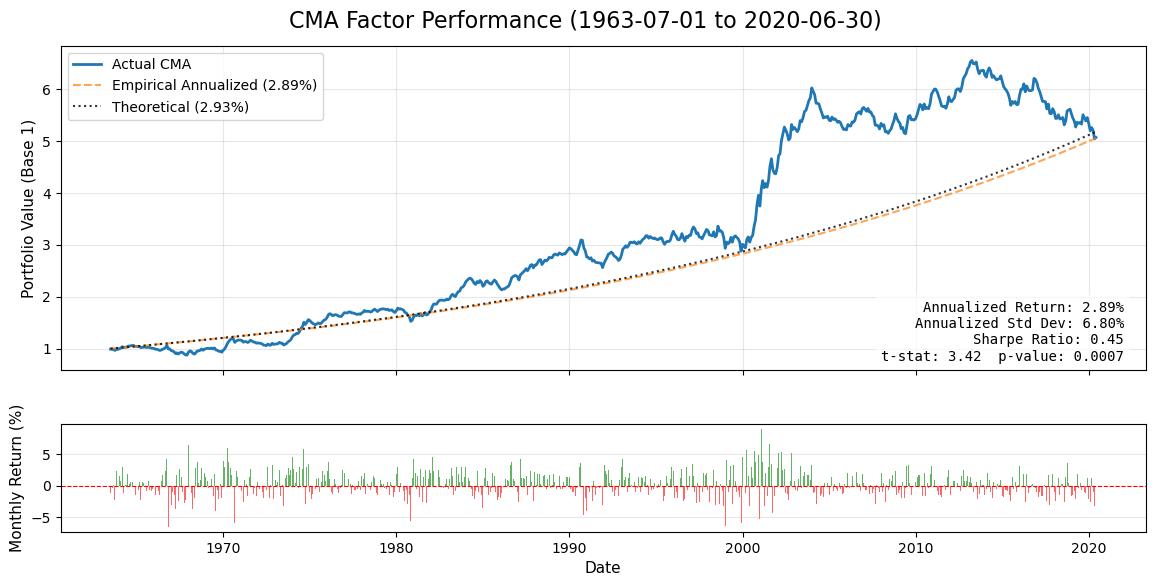

In [5]:
analyze_ff_factor(ff_factors, 'CMA')

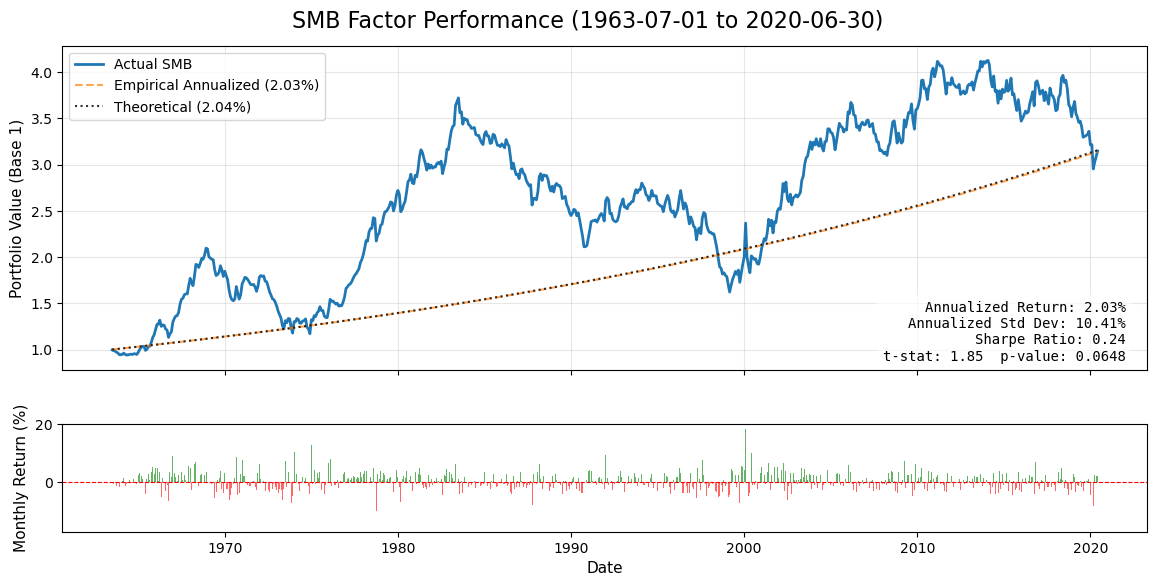

In [6]:
analyze_ff_factor(ff_factors, 'SMB')

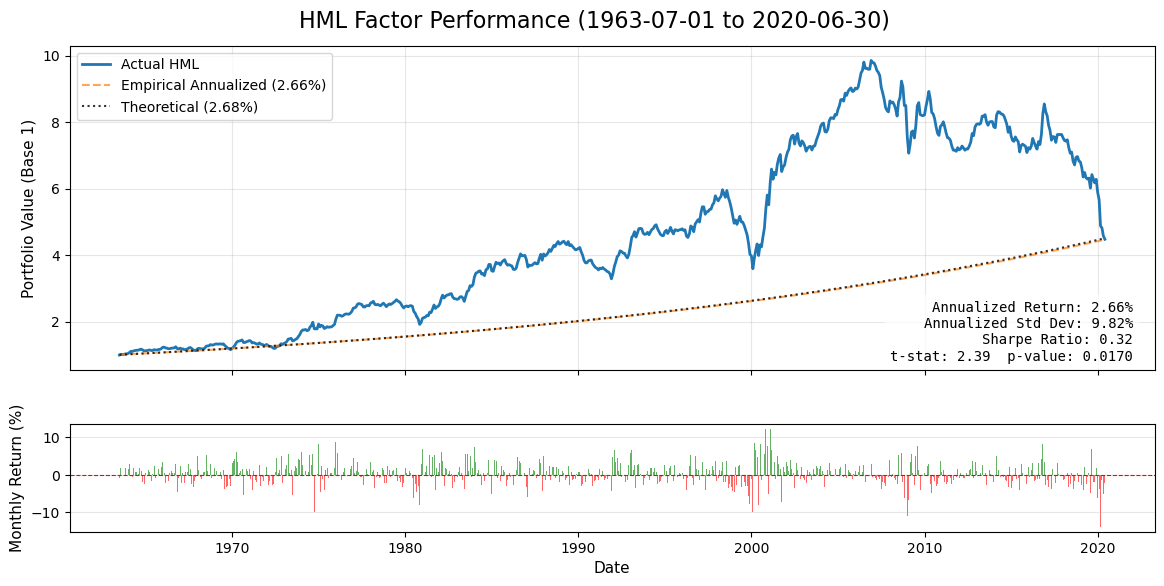

In [7]:
analyze_ff_factor(ff_factors, 'HML')

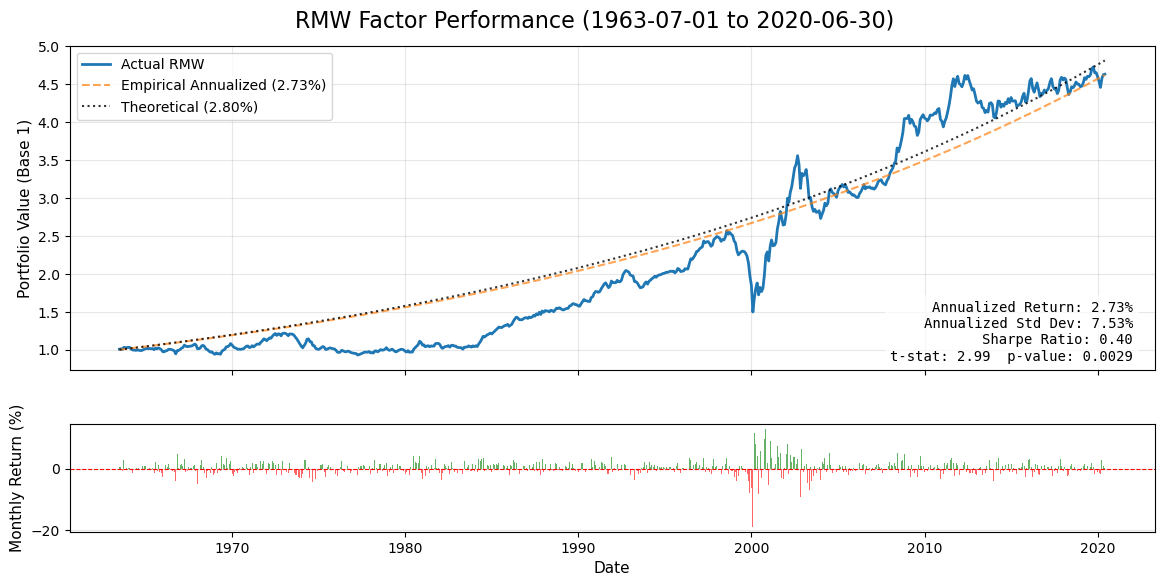

In [8]:
analyze_ff_factor(ff_factors, 'RMW')

We arrive at largely the same results in this implementation. Minor differences exist, which stems from updates in the methodology of building the academic portfolios between the publication of the original paper and this analysis. 

## Synthetic ETF and Rolling Factor Loadings

Now that we have validated our methodology for calculating the US Five-Factor premiums, we can turn our attention to **estimating factor exposures**, i.e., the sensitivities of an asset or portfolio to each of the underlying factors.  

To illustrate this process in a controlled environment, we begin with **synthetic data**: a theoretical ETF constructed from a combination of factor returns with predefined **time-varying loadings** (betas) and some added **imperfections or noise** to mimic real-world market conditions. This approach allows us to explore how well our regression methods can recover the true underlying exposures under different scenarios, such as:

- **Smooth, deterministic changes** in factor loadings (e.g., sinusoidal variations representing cyclical market behavior)  
- **Random fluctuations** representing idiosyncratic noise in factor sensitivities  

Once the synthetic ETF returns are generated, we apply **rolling regressions** over different time windows (e.g., 5-year and 10-year rolling windows) to estimate the factor loadings dynamically over time. This enables us to observe:

1. **How well the estimated betas track the true underlying exposures** for each factor  
2. **The effect of window length** on the smoothness and responsiveness of the estimates: shorter windows capture more local variation but are noisier, whereas longer windows produce smoother estimates but with slower responsiveness  
3. **The impact of random noise in the factors or loadings** on the precision of the regression estimates, illustrating the limitations of finite-sample rolling regressions in practice  

By comparing the **true synthetic loadings** with the **rolling estimated loadings**, we gain insight into the reliability and interpretability of factor regression techniques before applying them to actual ETF data. Additionally, this framework allows us to experiment with **dynamic loadings** and understand how different patterns of factor exposures manifest in estimated regressions — a useful tool for both academic exploration and practical portfolio analysis.


/tmp/ipykernel_72103/4289229823.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='1926-01-01', end='2024-01-01', freq='M')


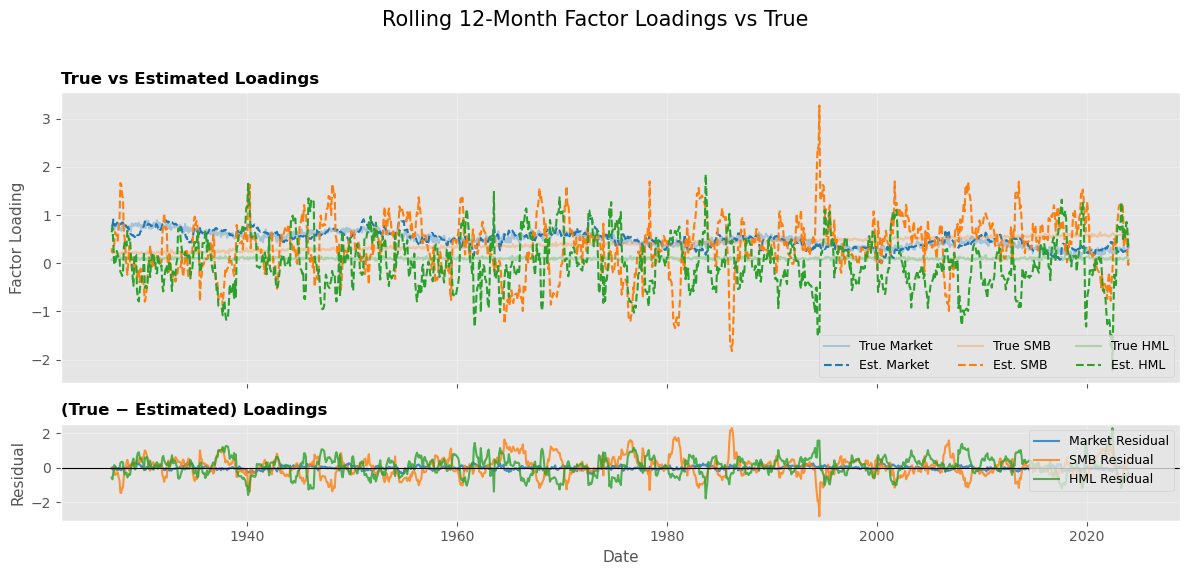

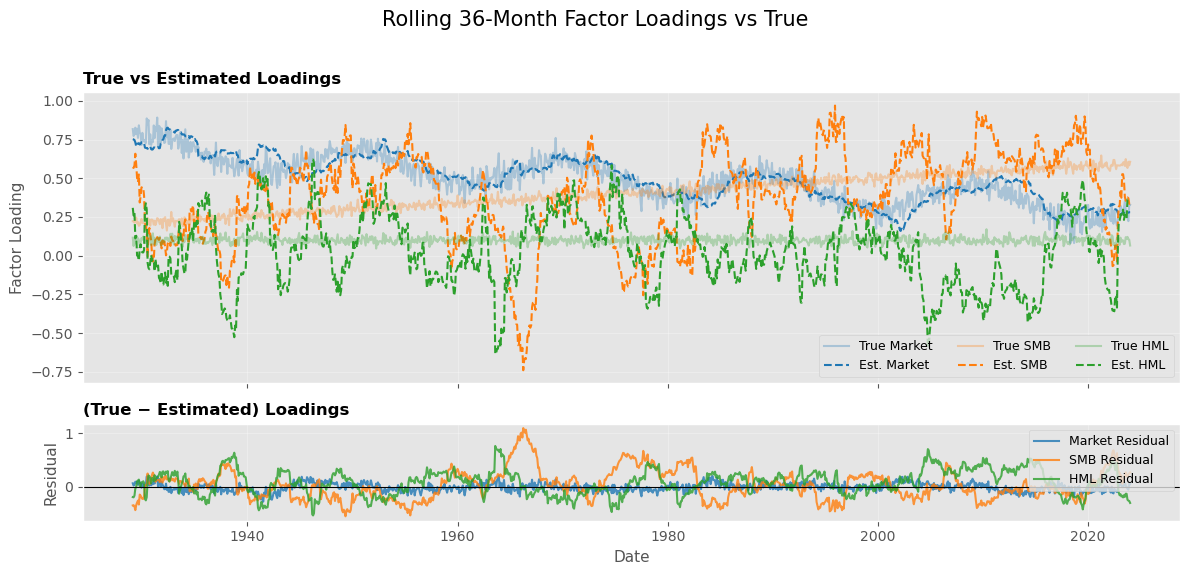

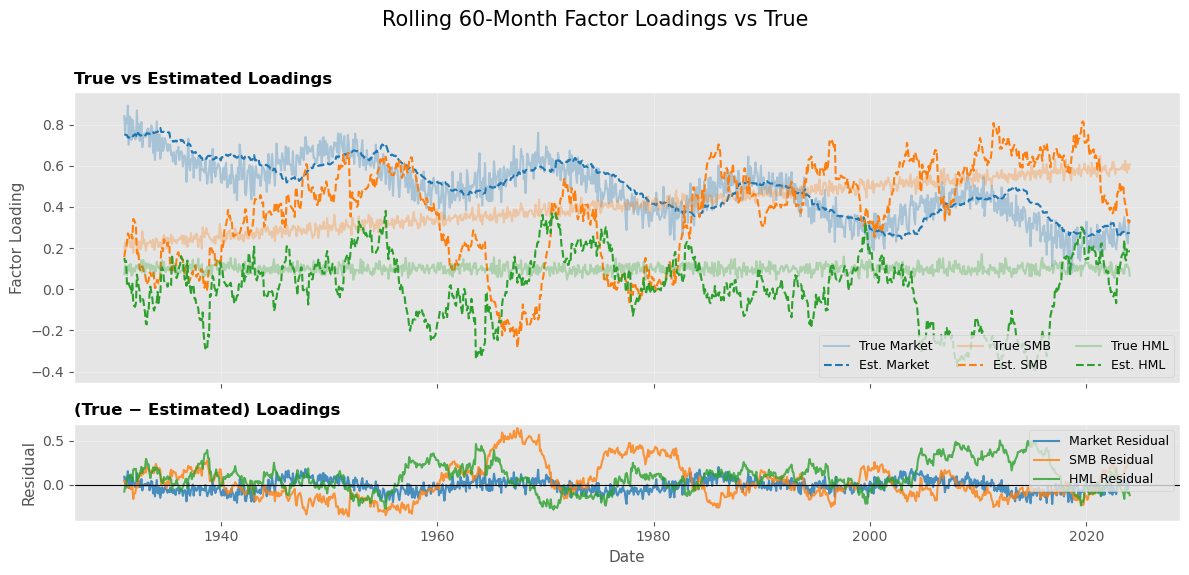

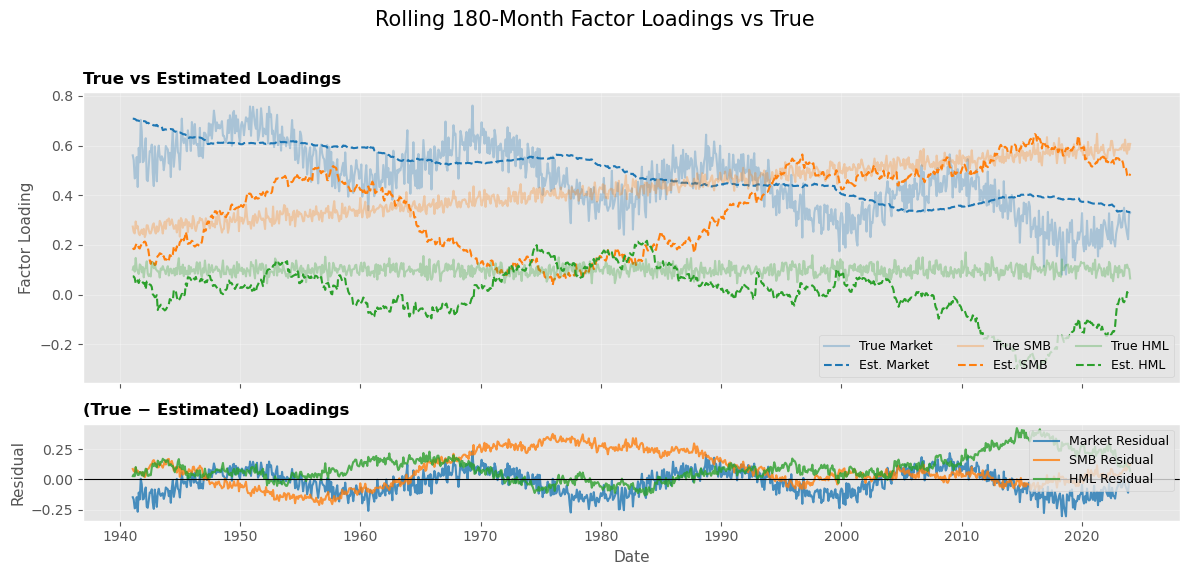

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Synthetic Data Generation ---
np.random.seed(42)
dates = pd.date_range(start='1926-01-01', end='2024-01-01', freq='M')
num_months = len(dates)
rf = 0.005/12 # Monthly Risk-Free Rate

# Simulate factor returns (monthly)
market_index_returns = np.random.normal(0.071/12, 0.07, num_months)
size_index_returns   = np.random.normal(0.08/12,  0.04/np.sqrt(12), num_months)
value_index_returns  = np.random.normal(0.095/12, 0.04/np.sqrt(12), num_months)

# --- Time-Varying Factor Loadings (True Loadings) ---
# Simulate loadings that drift randomly through time
true_loadings = pd.DataFrame({
    'Market': 0.7 + 0.1*np.sin(np.linspace(0, 10*np.pi, num_months)) + np.random.normal(0, 0.05, num_months) - 0.4*np.linspace(0, num_months, num_months)/num_months,
    'SMB': 0.2 + 0.4*np.linspace(0, num_months, num_months)/num_months + np.random.normal(0, 0.02, num_months),
    'HML': 0.1 + np.random.normal(0, 0.02, num_months)
}, index=dates)

# Recompute ETF returns with time-varying true_loadings and noise (ETF_TV)
returns_df = pd.DataFrame({
    'Date': dates,
    'ETF_TV': (
        true_loadings['Market']*market_index_returns +
        true_loadings['SMB']*size_index_returns +
        true_loadings['HML']*value_index_returns +
        np.random.normal(0, 0.015, num_months) # Idiosyncratic Noise (Alpha + Residual)
    ),
    'Market': market_index_returns,
    'SMB': size_index_returns,
    'HML': value_index_returns
}).set_index('Date')


plot_rolling_vs_true_combo(returns_df, true_loadings, windows=[12, 36, 60, 180])


## Choosing Rolling Window Length for Factor Loadings

When estimating factor loadings using rolling regressions, the choice of the **rolling window length** is critical. The window controls how much historical data is used for each regression, and it directly affects the smoothness and responsiveness of the estimated betas.

### Key Considerations

1. **Too small a window**
   - Estimates become highly **volatile**.
   - The regression reacts strongly to **short-term fluctuations** or noise.
   - While this captures local dynamics, it can be misleading and obscure the underlying factor structure.
   - Example: A 12-month rolling window often produces jagged, difficult-to-interpret beta estimates.

2. **Too large a window**
   - Estimates are **smooth**, but **slow to respond** to changes in factor exposures.
   - Features such as shifts in market regimes or evolving ETF strategies may be **washed out**.
   - Example: A 10-year window may miss subtle but important transitions in factor loadings.

### Practical Approaches

- **Experiment with multiple window lengths**
  - Compare, for instance, **5-year vs 10-year rolling windows**.
  - Allows you to balance short-term responsiveness with long-term stability.

- **Weighted or exponential rolling regressions**
  - Assign more weight to recent observations.
  - Smooths the estimates without ignoring new trends.

- **Adaptive window lengths**
  - Adjust the window dynamically based on market volatility or trading activity.
  - Larger windows during calm periods, smaller during high-volatility regimes.

- **Complement with other diagnostics**
  - Overlay true or benchmark loadings (if known) for validation.
  - Visualize cumulative returns or factor exposures to detect overfitting or noise.

Choosing the right rolling window is a **trade-off between responsiveness and stability**, and the optimal length may differ depending on the asset, factor, or market conditions. In practice, it is often useful to test several reasonable window lengths and inspect the resulting beta dynamics visually.


## ZPRV and ZPRX Analysis with Rolling Factor Loadings

In this section, we analyze the **ZPRV** (SPDR MSCI Europe Value UCITS ETF) and **ZPRX** (SPDR MSCI Europe Small Cap Value UCITS ETF) and calculate their rolling factor loadings against the Fama-French 5-Factor model.

[*********************100%***********************]  2 of 2 completed


[*********************100%***********************]  1 of 1 completed

Ticker       Date    ZPRV.DE    ZPRX.DE  USDEUR=X
0      2015-02-18  30.086201  30.372190   0.87683
1      2015-02-19  30.081800  30.371180   0.87719
2      2015-02-20  26.480000  30.540001   0.87976
3      2015-02-23  26.559999  30.730000   0.87862
4      2015-02-24  26.700001  30.830000   0.88238
...           ...        ...        ...       ...
2737   2025-11-28  66.959999  60.189999   0.86208
2738   2025-12-01  66.959999  59.810001   0.86196
2739   2025-12-02  66.669998  59.759998   0.86150
2740   2025-12-03  67.050003  59.790001   0.86000
2741   2025-12-04  67.110001  60.189999   0.85713

[2742 rows x 4 columns]



/tmp/ipykernel_2460/1030309767.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = (1 + merged[tickers]).resample('M').last().pct_change().dropna()


            Mkt-RF     SMB     HML     RMW     CMA      RF
                                                          
1963-07-01 -0.0039 -0.0048 -0.0081  0.0064 -0.0115  0.0027
1963-08-01  0.0508 -0.0080  0.0170  0.0040 -0.0038  0.0025
1963-09-01 -0.0157 -0.0043  0.0000 -0.0078  0.0015  0.0027
1963-10-01  0.0254 -0.0134 -0.0004  0.0279 -0.0225  0.0029
1963-11-01 -0.0086 -0.0085  0.0173 -0.0043  0.0227  0.0027
...            ...     ...     ...     ...     ...     ...
2025-07-01  0.0198 -0.0015 -0.0127 -0.0029 -0.0207  0.0034
2025-08-01  0.0185  0.0488  0.0442 -0.0067  0.0208  0.0038
2025-09-01  0.0339 -0.0218 -0.0105 -0.0203 -0.0222  0.0033
2025-10-01  0.0196 -0.0131 -0.0309 -0.0522 -0.0403  0.0037
2025-11-01 -0.0013  0.0147  0.0376  0.0143  0.0068  0.0030

[749 rows x 6 columns]

Processing ZPRV.DE...


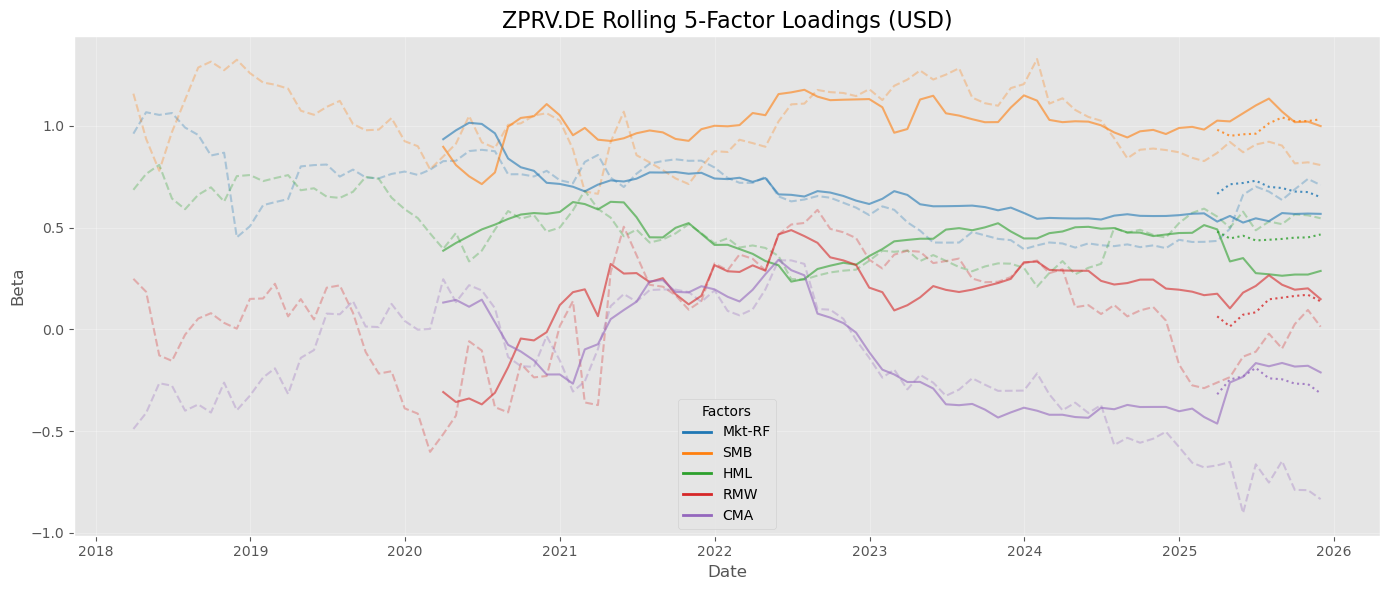


Processing ZPRX.DE...


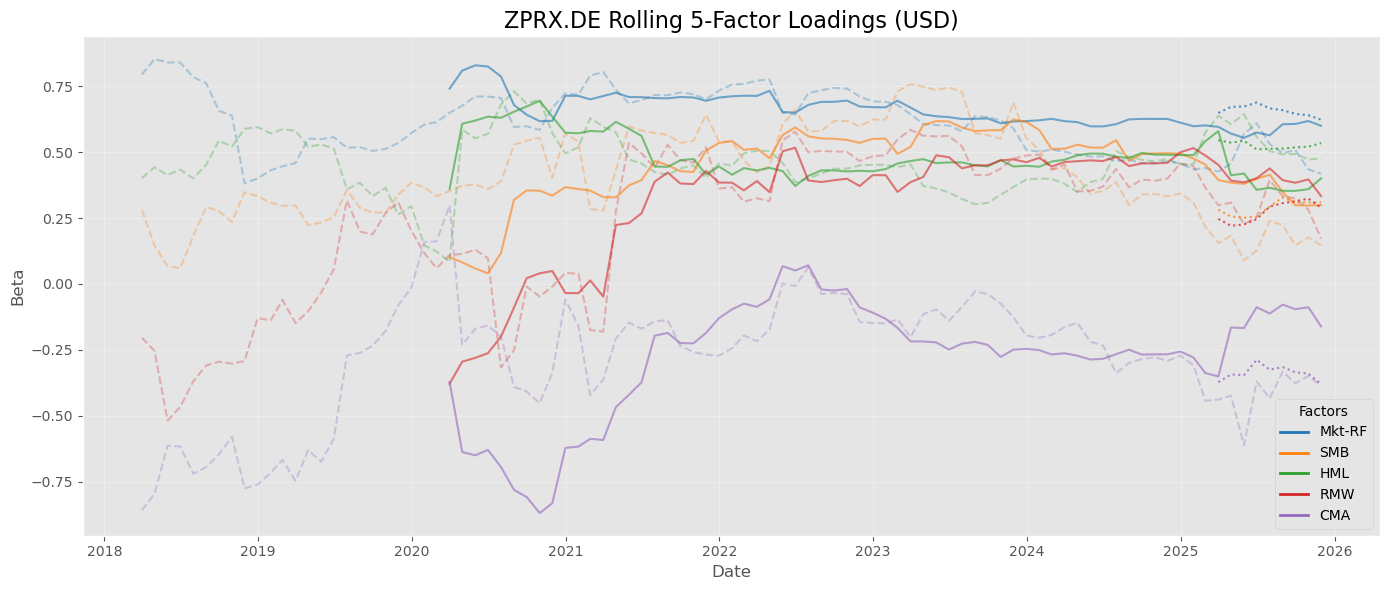

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.lines import Line2D

# --- Settings ---
tickers = ['ZPRV.DE', 'ZPRX.DE']
start_date, end_date = '2015-01-01', '2025-12-05'
windows = [36, 60, 120]  # 3Y, 5Y, 10Y
factor_colors = {'Mkt-RF':'tab:blue','SMB':'tab:orange','HML':'tab:green','RMW':'tab:red','CMA':'tab:purple'}

# --- Download ETF prices ---
print("Downloading ETF price data...")
price_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close'].reset_index()

# --- Download EUR/USD FX data ---
print("Downloading EUR/USD FX data...")
conv_ticker = 'EURUSD=X'
eurusd = yf.download(conv_ticker, start=start_date, end=end_date, auto_adjust=True)['Close'].reset_index()

# --- Merge and convert ETFs to USD ---
merged = pd.merge(price_data, eurusd, on='Date', how='inner')
print(merged)
for col in tickers:
    merged[col] = merged[col] * merged[conv_ticker]

merged['Date'] = pd.to_datetime(merged['Date'])
merged.set_index('Date', inplace=True)

# --- Monthly returns ---
monthly_returns = (1 + merged[tickers]).resample('M').last().pct_change().dropna()

# --- Load Fama-French 5 Factors ---
ff_factors = fetch_ff5_monthly(region="US")
print(ff_factors)
ff_factors.index = pd.to_datetime(ff_factors.index).to_period('M').to_timestamp('M')

# --- Combine ETFs & Factors ---
combined_data = pd.concat([monthly_returns, ff_factors], axis=1, join='inner')

# --- Plotting ---
for etf_col in tickers:
    print(f"\nProcessing {etf_col}...")
    etf_df = combined_data.copy()
    etf_df['excess'] = etf_df[etf_col] - etf_df['RF']

    plt.figure(figsize=(14,6))

    for w in windows:
        rolling = rolling_factor_loadings_5f(etf_df, w)
        for factor in rolling.columns:
            plt.plot(
                rolling.index, rolling[factor],
                color=factor_colors[factor],
                linestyle='--' if w==36 else '-' if w==60 else ':',
                alpha=0.3 if w==36 else 0.6 if w==60 else 0.8,
                label=f'{factor} ({w//12}Y)' if w==36 else None
            )

    plt.title(f'{etf_col} Rolling 5-Factor Loadings (USD)', fontsize=16)
    plt.ylabel('Beta')
    plt.xlabel('Date')
    plt.grid(alpha=0.3)

    # Custom legend
    lines = [Line2D([0],[0], color=factor_colors[f], lw=2) for f in factor_colors]
    labels = factor_colors.keys()
    plt.legend(lines, labels, title='Factors', fontsize=10)

    plt.tight_layout()
    plt.show()



Regression Results for ZPRV.DE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     543.0
Date:                Fri, 16 Jan 2026   Prob (F-statistic):           5.16e-82
Time:                        07:24:43   Log-Likelihood:                 379.19
No. Observations:                 129   AIC:                            -746.4
Df Residuals:                     123   BIC:                            -729.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.000

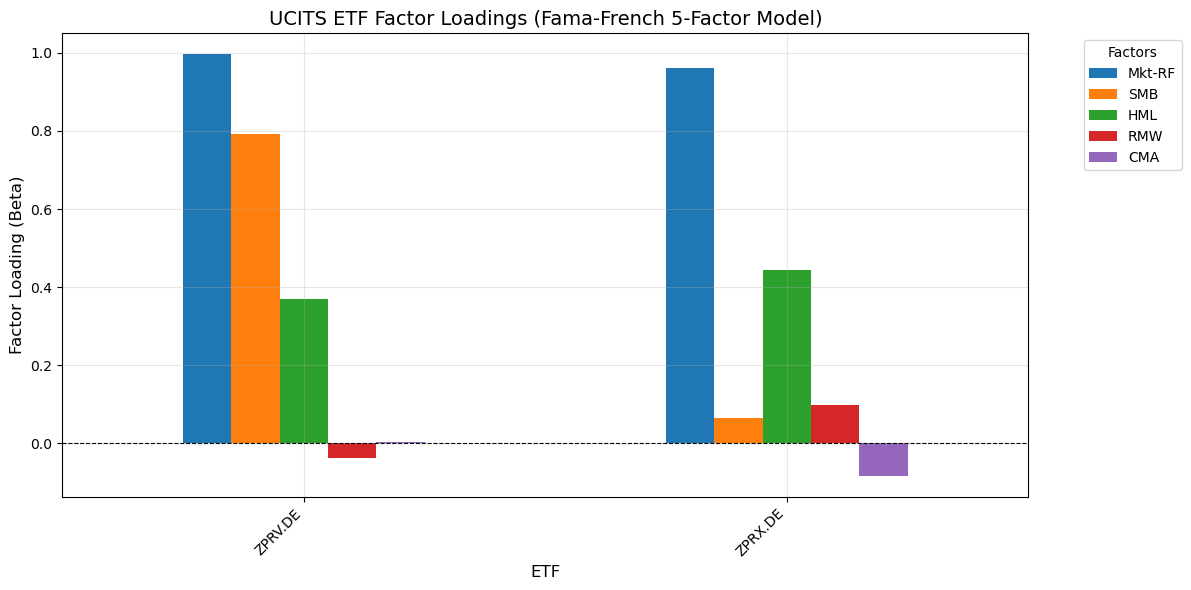


Factor Loadings Summary (Beta coefficients):
           Mkt-RF       SMB       HML       RMW       CMA
ZPRV.DE  0.996072  0.793489  0.369362 -0.036105  0.004596
ZPRX.DE  0.961421  0.065489  0.443197  0.097075 -0.082280


In [10]:


etf_cols = ['ZPRV.DE', 'ZPRX.DE']
factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

ucits_combined = combined_data.copy()

# Run 5-Factor regressions
for etf in etf_cols:
    print(f"\n{'='*60}")
    print(f"Regression Results for {etf}")
    print(f"{'='*60}")
    
    # Compute excess returns (ETF minus risk-free)
    y = ucits_combined[etf] - ucits_combined['RF']
    
    # Independent variables
    X = sm.add_constant(ucits_combined[factor_cols])
    
    # Run OLS regression
    model = sm.OLS(y, X).fit()
    
    # Full regression summary
    print(model.summary())
    
    # Key statistics
    alpha = model.params['const']
    alpha_t = model.tvalues['const']
    r2 = model.rsquared
    r2_adj = model.rsquared_adj
    
    print(f"\nKey Statistics for {etf}:")
    print(f"Alpha (excess return unexplained by factors): {alpha:.4f} (t-stat: {alpha_t:.2f})")
    print(f"R-squared: {r2:.4f} (proportion of variance explained by factors)")
    print(f"Adjusted R-squared: {r2_adj:.4f} (accounts for number of factors)")

    print("\nFactor Loadings (Betas):")
    for factor in factor_cols:
        beta = model.params[factor]
        t_stat = model.tvalues[factor]
        significance = 'significant' if abs(t_stat) > 2 else 'not significant'
        print(f"  {factor}: {beta:.4f} (t-stat: {t_stat:.2f}) → {significance}")

# Visualize factor loadings
loadings_dict = {}
for etf in etf_cols:
    y = ucits_combined[etf] - ucits_combined['RF']
    X = sm.add_constant(ucits_combined[factor_cols])
    model = sm.OLS(y, X).fit()
    loadings_dict[etf] = model.params[factor_cols]

loadings_df = pd.DataFrame(loadings_dict).T

# Bar plot
fig, ax = plt.subplots(figsize=(12, 6))
loadings_df.plot(kind='bar', ax=ax)
ax.set_title('UCITS ETF Factor Loadings (Fama-French 5-Factor Model)', fontsize=14)
ax.set_xlabel('ETF', fontsize=12)
ax.set_ylabel('Factor Loading (Beta)', fontsize=12)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(True, alpha=0.3)
ax.legend(title='Factors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary printout
print("\nFactor Loadings Summary (Beta coefficients):")
print(loadings_df)



The rolling factor loadings function has been tested on the longer-scale proprietary [*MSCI USA Small Cap Value Index*](https://curvo.eu/backtest/en/market-index/msci-usa-small-cap-value?currency=eur) dataset from [*Curvo.eu*](https://curvo.eu/) and previously published results in the [*Rational Reminder Community*](https://community.rationalreminder.ca/). While the proprietary data isn't included in this repository, the analysis of the ETFs in the current sample indicates the following:  

- **ZPRV**: Exhibits strong and consistent factor loadings across the five Fama-French factors.  
- **ZPRX**: Shows decent loadings, though somewhat less pronounced than ZPRV.  
- **CMA Factor**: Both ETFs, particularly in recent periods, are experiencing slightly negative exposures to the CMA factor.  

Overall, the rolling regressions appear reasonable and consistent with expected industry-level factor behavior.

## Reconstructing Returns Using the 5-Factor Model

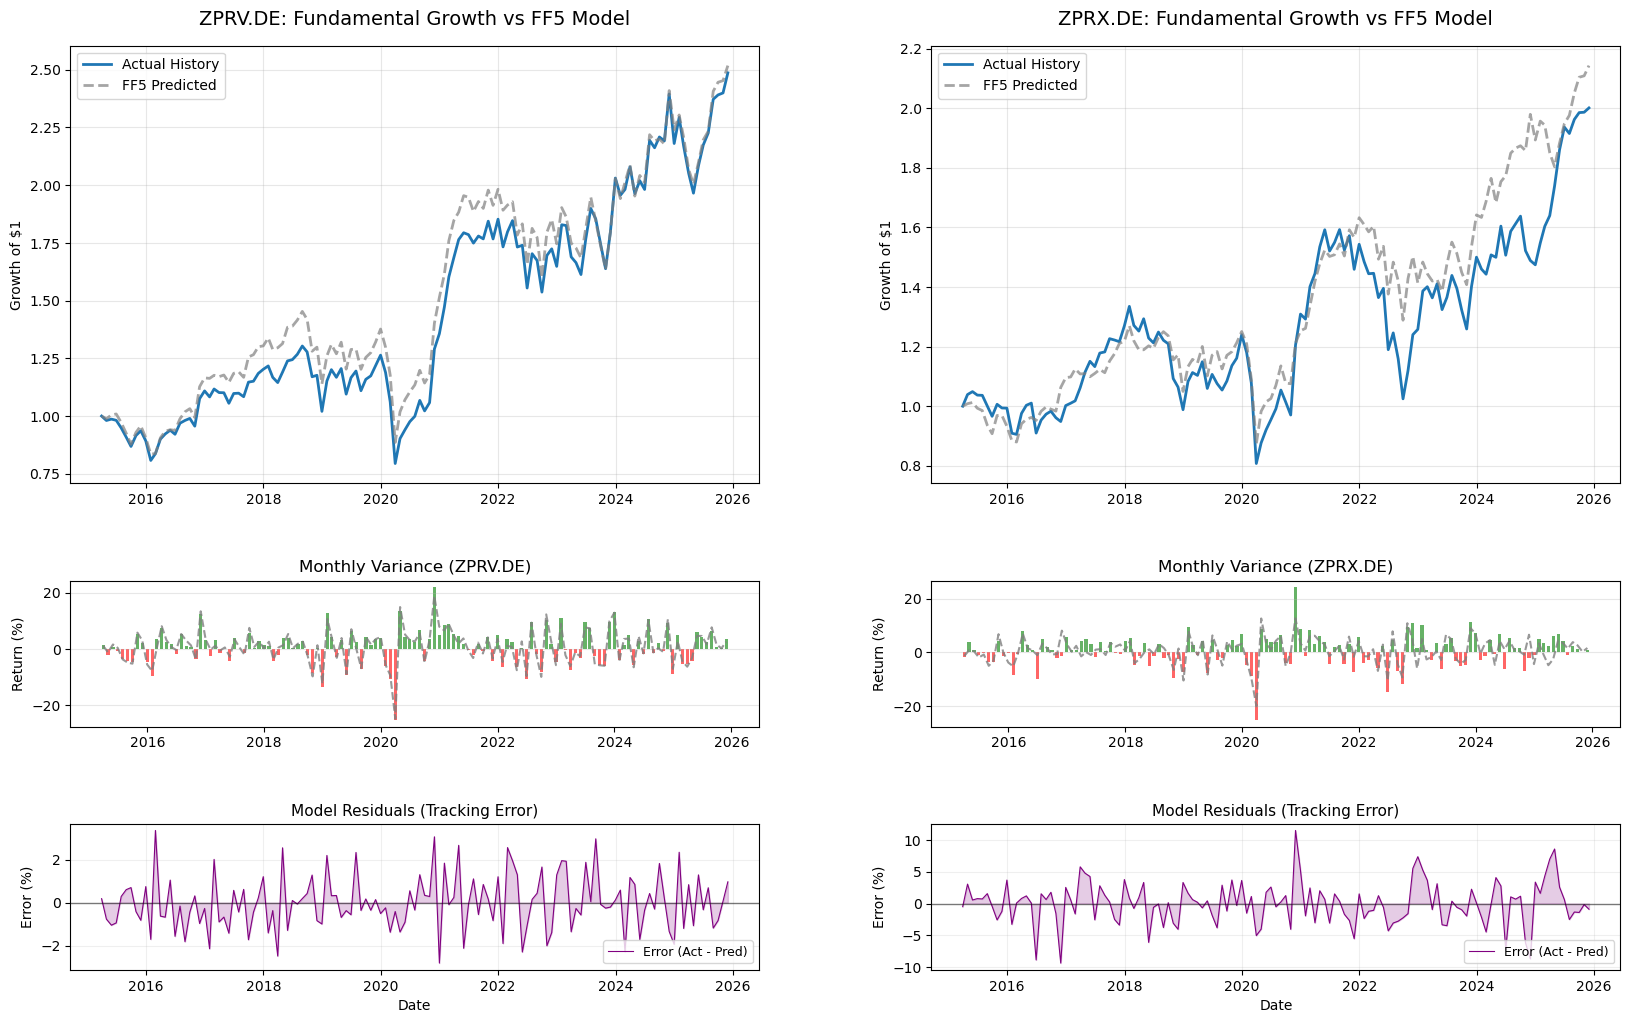

In [11]:
# Prepare predicted returns from Fama-French regressions
predicted_returns = {}
for etf in etf_cols:
    y = ucits_combined[etf] - ucits_combined['RF']
    X = sm.add_constant(ucits_combined[factor_cols])
    model = sm.OLS(y, X).fit()
    # Predicted excess returns + RF to get actual return
    predicted_returns[etf] = model.predict(X) + ucits_combined['RF']

# Colors for plotting
colors = {'Actual': 'tab:blue', 'Predicted': 'tab:grey', 'Residual': 'purple'}

# Create a 3-row grid: Cumulative (Large), Monthly (Medium), Residuals (Small)
fig, axes = plt.subplots(3, 2, figsize=(20, 12), 
                         gridspec_kw={'height_ratios': [3, 1, 1], 'hspace': 0.4, 'wspace': 0.25})

for i, etf in enumerate(etf_cols):
    actual = ucits_combined[etf].loc[predicted_returns[etf].index]
    pred = predicted_returns[etf]
    # Residuals in percentage points
    residuals = (actual - pred) * 100 
    
    # -----------------------------
    # Row 0: Cumulative Growth
    # -----------------------------
    cum_actual = (1 + actual).cumprod()
    cum_actual /= cum_actual.iloc[0]  
    cum_pred = (1 + pred).cumprod()
    cum_pred /= cum_pred.iloc[0]
    
    axes[0, i].plot(cum_actual.index, cum_actual, color=colors['Actual'], linewidth=2, label='Actual History')
    axes[0, i].plot(cum_pred.index, cum_pred, color=colors['Predicted'], linestyle='--', linewidth=2, alpha=0.7, label='FF5 Predicted')
    
    axes[0, i].set_title(f'{etf}: Fundamental Growth vs FF5 Model', fontsize=14, pad=15)
    axes[0, i].set_ylabel('Growth of $1')
    axes[0, i].grid(alpha=0.3)
    axes[0, i].legend(loc='upper left')
    
    # -----------------------------
    # Row 1: Monthly Returns (Bar vs Line)
    # -----------------------------
    colors_actual = ['green' if x > 0 else 'red' for x in actual * 100]
    axes[1, i].bar(actual.index, actual * 100, color=colors_actual, alpha=0.6, width=20, label='Actual')
    axes[1, i].plot(pred.index, pred * 100, color=colors['Predicted'], linestyle='--', alpha=0.8, linewidth=1.5, label='Predicted')

    axes[1, i].set_title(f'Monthly Variance ({etf})', fontsize=12)
    axes[1, i].set_ylabel('Return (%)')
    axes[1, i].grid(True, axis='y', alpha=0.3)
    
    # -----------------------------
    # Row 2: Residuals (The Discrepancy)
    # -----------------------------
    # Using a stem plot or fill_between is often cleaner for residuals
    axes[2, i].fill_between(residuals.index, residuals, 0, color=colors['Residual'], alpha=0.2)
    axes[2, i].plot(residuals.index, residuals, color=colors['Residual'], linewidth=0.8, label='Error (Act - Pred)')
    
    # Baseline zero-line is critical for residual plots
    axes[2, i].axhline(0, color='black', lw=1, alpha=0.5)
    
    axes[2, i].set_title(f'Model Residuals (Tracking Error)', fontsize=11)
    axes[2, i].set_ylabel('Error (%)')
    axes[2, i].set_xlabel('Date')
    axes[2, i].grid(alpha=0.2)
    axes[2, i].legend(fontsize=9, loc='lower right')

# Use tight_layout to handle the spacing after adding the third row
plt.show()

From the figures above, we can visualise the famous explanatory power of the Fama-French Five Factor model, the predicted returns, plotted in grey, closely match the ETFs price chart. This result is used in our retirement spending Block-Bootstrap Monte Carlo simulations to create synthetic historical returns for newer products with insufficient historical samples. This is to be understood as a plausible model, not a perfect reconstruction of a hypothetical past.  
  
The following is a direct analysis of the MSCI USA SCV index which is tracked by the European ETF ZPRV. 

/tmp/ipykernel_2460/2189957021.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw = pd.read_csv(csv_path, parse_dates=['Date'], dayfirst=False)


Loaded 369 price rows, computed 368 monthly returns.
Fama-French factors date range: 1963-07-31 00:00:00 to 2025-11-30 00:00:00
✓ Combined data shape: (368, 8)
              ETF_TV  Market     SMB     HML     RMW     CMA      RF    excess
1994-12-31  0.019656  0.0086 -0.0005 -0.0009  0.0040  0.0036  0.0044  0.015256
1995-01-31 -0.002752  0.0180 -0.0307  0.0259  0.0015 -0.0065  0.0042 -0.006952
1995-02-28  0.044365  0.0363 -0.0049  0.0099  0.0061 -0.0040  0.0040  0.040365
1995-03-31  0.012398  0.0219 -0.0053 -0.0213 -0.0013  0.0023  0.0046  0.007798
1995-04-30  0.024666  0.0211 -0.0026  0.0167  0.0043  0.0082  0.0044  0.020266
Rolling betas (first rows):
              Market       SMB       HML       RMW       CMA
1999-12-31  1.025153  0.818890  0.420472  0.144465 -0.021665
2000-01-31  1.037829  0.825652  0.425937  0.256927  0.002849
2000-02-29  1.035966  0.820956  0.442329  0.251209 -0.016373
2000-03-31  1.039073  0.797858  0.453868  0.428609 -0.073544
2000-04-30  1.040803  0.782927  0

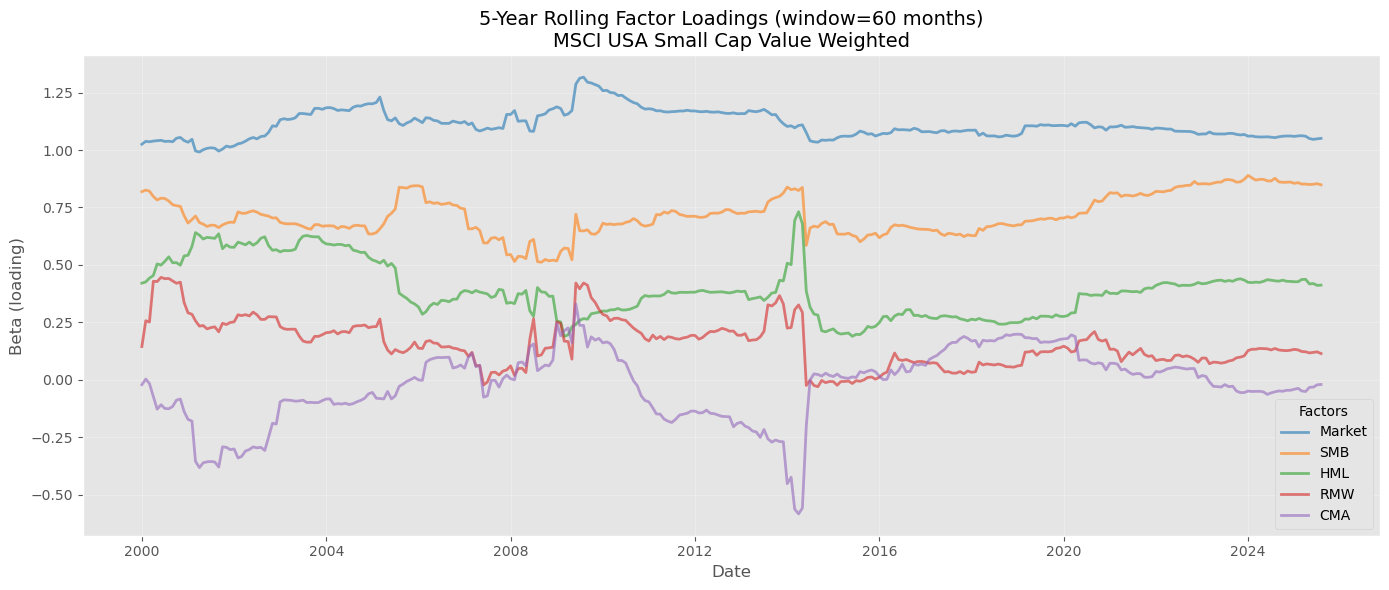

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


# --- Load ETF CSV ---
csv_path = "../data/MSCI_USA_SCV.csv"
window_months = 60  # 5-year rolling window

df_raw = pd.read_csv(csv_path, parse_dates=['Date'], dayfirst=False)

# Ensure datetime index
df_raw = df_raw.dropna(subset=['Date']).copy()
df_raw.set_index('Date', inplace=True)
df_raw.index = df_raw.index.to_period('M').to_timestamp('M')

# Detect the ETF column
col_name = [c for c in df_raw.columns if 'MSCI' in c][0]
price = df_raw[col_name].astype(float)

# Compute monthly returns
returns = price.pct_change().rename('ETF_ret').dropna()
print(f"Loaded {len(price)} price rows, computed {len(returns)} monthly returns.")

# --- Fetch Fama-French 5 Factors ---
ff = fetch_ff5_monthly(region="US")
ff = ff.replace(-99, np.nan)  # missing marker
ff.index = ff.index.to_period('M').to_timestamp('M')
ff = ff[['Mkt-RF','SMB','HML','RMW','CMA','RF']].copy()

# Convert % to decimal if necessary
if ff[['Mkt-RF','SMB','HML','RMW','CMA','RF']].abs().median().max() > 1.0:
    ff[['Mkt-RF','SMB','HML','RMW','CMA','RF']] /= 100.0
    print("Converted FF5 factors from percent to decimal.")

print(f"Fama-French factors date range: {ff.index[0]} to {ff.index[-1]}")

# --- Combine ETF returns with factors ---
combined = pd.concat([returns, ff], axis=1, join='inner').dropna()
combined.rename(columns={'ETF_ret':'ETF_TV','Mkt-RF':'Market'}, inplace=True)

# Compute excess returns for rolling regression
combined['excess'] = combined['ETF_TV'] - combined['RF']

print(f"✓ Combined data shape: {combined.shape}")
print(combined.head())

# --- Rolling beta function ---
def rolling_factor_loadings_5f(df, window):
    X = sm.add_constant(df[['Market','SMB','HML','RMW','CMA']])
    betas = []
    idx = []
    for i in range(window, len(df)):
        ywin = df['excess'].iloc[i-window:i]
        Xwin = X.iloc[i-window:i]
        model = sm.OLS(ywin, Xwin).fit()
        betas.append(model.params.drop('const'))
        idx.append(df.index[i])
    return pd.DataFrame(betas, index=idx)

# --- Compute rolling betas ---
betas_5y = rolling_factor_loadings_5f(combined, window=window_months)
print(f"Rolling betas (first rows):\n{betas_5y.head()}")

# --- Plot ---
plt.style.use('ggplot')  # or 'fivethirtyeight', 'classic', 'bmh'
plt.figure(figsize=(14,6))

factor_colors = {
    'Market': 'tab:blue',
    'SMB': 'tab:orange',
    'HML': 'tab:green',
    'RMW': 'tab:red',
    'CMA': 'tab:purple'
}

for factor, color in factor_colors.items():
    plt.plot(betas_5y.index, betas_5y[factor], label=factor, color=color, linewidth=2, alpha=0.6)

plt.title(f'5-Year Rolling Factor Loadings (window={window_months} months)\nMSCI USA Small Cap Value Weighted', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Beta (loading)')
plt.legend(title='Factors', loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Correlation matrix of rolling factor loadings:
          Market       SMB       HML       RMW       CMA
Market  1.000000  0.693158  0.124012  0.444384 -0.271640
SMB     0.693158  1.000000  0.066565  0.626127 -0.280506
HML     0.124012  0.066565  1.000000  0.160341 -0.847211
RMW     0.444384  0.626127  0.160341  1.000000 -0.382002
CMA    -0.271640 -0.280506 -0.847211 -0.382002  1.000000


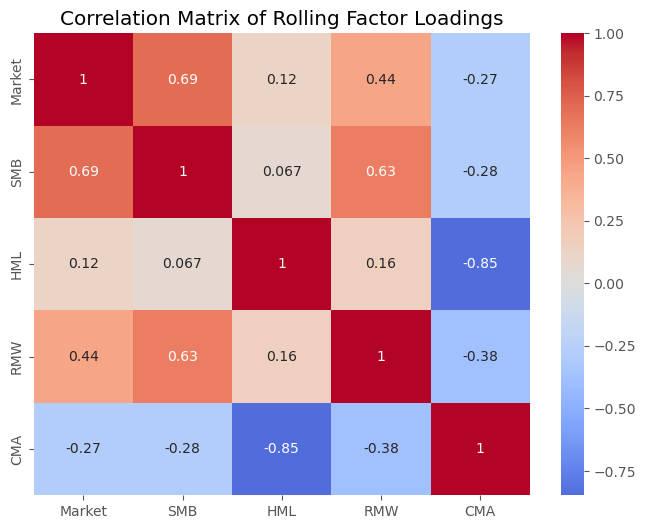

In [12]:
# drop initial NaNs
betas_clean = betas_5y.dropna()

# correlation matrix
corr_matrix = betas_clean.corr()
print("Correlation matrix of rolling factor loadings:")
print(corr_matrix)

import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Rolling Factor Loadings")
plt.show()



Regression Results for MSCI USA Small Cap Value Weighted
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     335.6
Date:                Sun, 11 Jan 2026   Prob (F-statistic):          1.67e-133
Time:                        06:51:05   Log-Likelihood:                 833.26
No. Observations:                 368   AIC:                            -1655.
Df Residuals:                     362   BIC:                            -1631.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

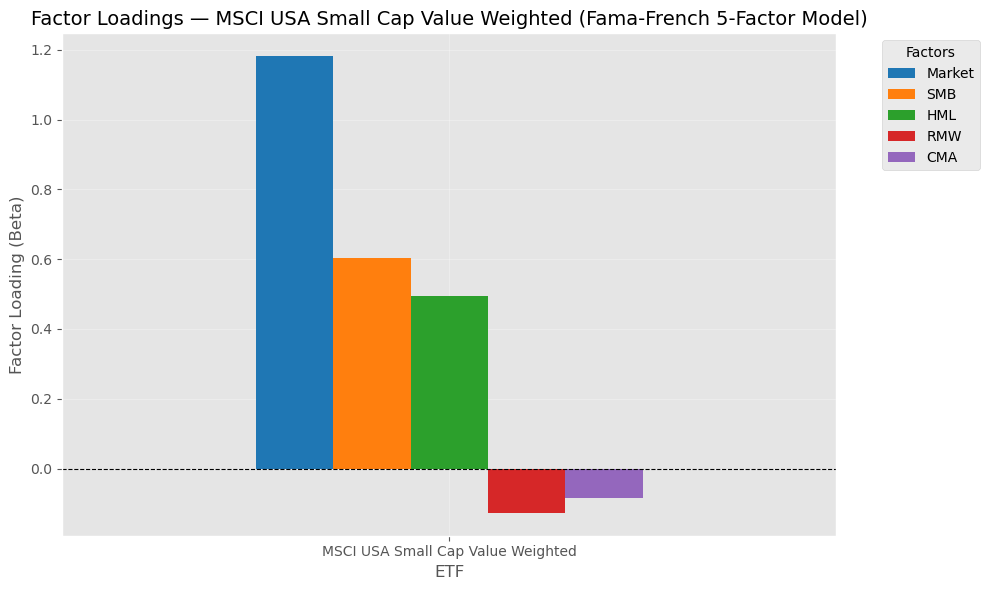

In [13]:
# -----------------------------
# Static 5-Factor Regression (Bar Plot)
# -----------------------------
# Compute excess returns (ETF minus risk-free)
y = combined['ETF_TV'] - combined['RF']

# Independent variables (add constant for alpha)
X = sm.add_constant(combined[['Market', 'SMB', 'HML', 'RMW', 'CMA']])

# Run OLS regression
model = sm.OLS(y, X).fit()

# Display key results
print("\n" + "="*60)
print("Regression Results for MSCI USA Small Cap Value Weighted")
print("="*60)
print(model.summary())

# Key statistics
alpha = model.params['const']
alpha_t = model.tvalues['const']
r2 = model.rsquared
r2_adj = model.rsquared_adj

print(f"\nAlpha (excess return unexplained by factors): {alpha:.4f} (t-stat: {alpha_t:.2f})")
print(f"R-squared: {r2:.4f} (proportion of variance explained by factors)")
print(f"Adjusted R-squared: {r2_adj:.4f} (accounts for number of factors)")

print("\nFactor Loadings (Betas):")
for factor in ['Market', 'SMB', 'HML', 'RMW', 'CMA']:
    beta = model.params[factor]
    t_stat = model.tvalues[factor]
    significance = 'significant' if abs(t_stat) > 2 else 'not significant'
    print(f"  {factor}: {beta:.4f} (t-stat: {t_stat:.2f}) → {significance}")

# -----------------------------
# Visualize factor loadings as bar plot
# -----------------------------
loadings_df = pd.DataFrame(model.params[['Market', 'SMB', 'HML', 'RMW', 'CMA']]).T
loadings_df.index = ['MSCI USA Small Cap Value Weighted']

fig, ax = plt.subplots(figsize=(10, 6))
loadings_df.plot(kind='bar', ax=ax, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
ax.set_title('Factor Loadings — MSCI USA Small Cap Value Weighted (Fama-French 5-Factor Model)', fontsize=14)
ax.set_xlabel('ETF', fontsize=12)
ax.set_ylabel('Factor Loading (Beta)', fontsize=12)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(True, alpha=0.3)
ax.legend(title='Factors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


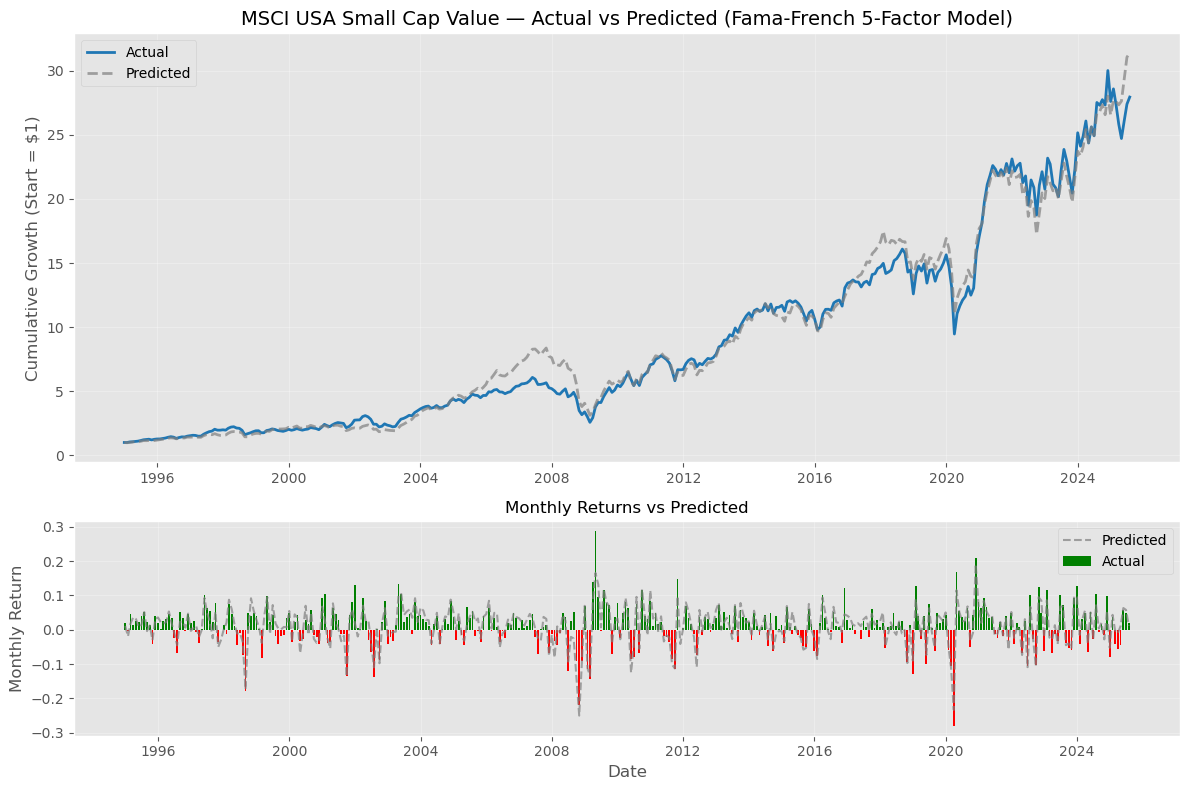

In [14]:
import matplotlib.pyplot as plt

# --- Make sure the column exists ---
etf_col = 'ETF_TV'  # replace with your actual column name if different
if etf_col not in combined.columns:
    raise ValueError(f"{etf_col} not in combined.columns: {combined.columns}")

# --- Predict ETF returns ---
y = combined[etf_col] - combined['RF']
X = sm.add_constant(combined[['Market', 'SMB', 'HML', 'RMW', 'CMA']])
model = sm.OLS(y, X).fit()
predicted = model.predict(X) + combined['RF']
actual = combined[etf_col]

# Drop NaNs
valid_idx = actual.dropna().index.intersection(predicted.dropna().index)
if len(valid_idx) == 0:
    raise ValueError("No valid data points for plotting (all NaNs?)")

actual = actual.loc[valid_idx]
predicted = predicted.loc[valid_idx]

# --- Cumulative returns (normalize to start at 1) ---
cum_actual = (1 + actual).cumprod()
cum_actual = cum_actual / cum_actual.iloc[0]
cum_pred = (1 + predicted).cumprod()
cum_pred = cum_pred / cum_pred.iloc[0]

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios':[2,1]})
colors = {'Actual':'tab:blue', 'Predicted':'tab:grey'}

# Cumulative
axes[0].plot(cum_actual.index, cum_actual, color=colors['Actual'], linewidth=2, label='Actual')
axes[0].plot(cum_pred.index, cum_pred, color=colors['Predicted'], alpha=0.7, linestyle='--', linewidth=2, label='Predicted')
axes[0].set_title(f"MSCI USA Small Cap Value — Actual vs Predicted (Fama-French 5-Factor Model)", fontsize=14)
axes[0].set_ylabel("Cumulative Growth (Start = $1)")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Monthly returns
colors_actual = ['green' if x > 0 else 'red' for x in actual]
axes[1].bar(actual.index, actual, color=colors_actual, alpha=1, width=20, label='Actual')
axes[1].plot(predicted.index, predicted, color=colors['Predicted'], alpha=0.7, linestyle='--', label='Predicted')
axes[1].set_title("Monthly Returns vs Predicted", fontsize=12)
axes[1].set_ylabel("Monthly Return")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



## Pedagogical Block Bootstrap Simulation
This cell demonstrates, step by step, how a block-bootstrap Monte Carlo simulation works for a simple ETF portfolio.
We will generate synthetic returns, sample blocks, string them together, and simulate withdrawals.

First, we start with a historical returns dataset.



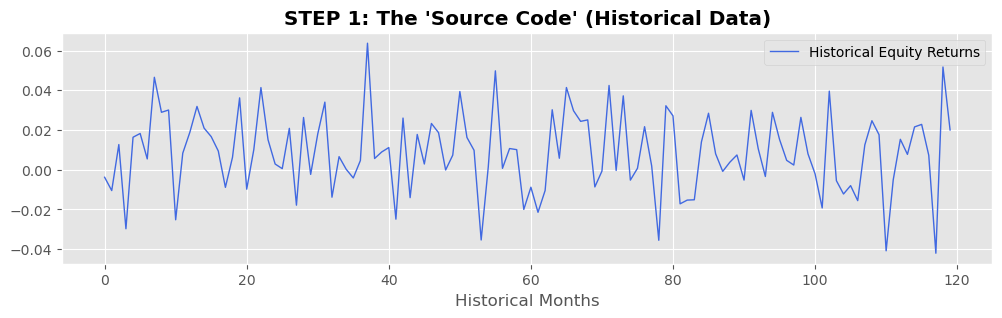

Then we randomly select chunks of returns data with a chosen average block size.



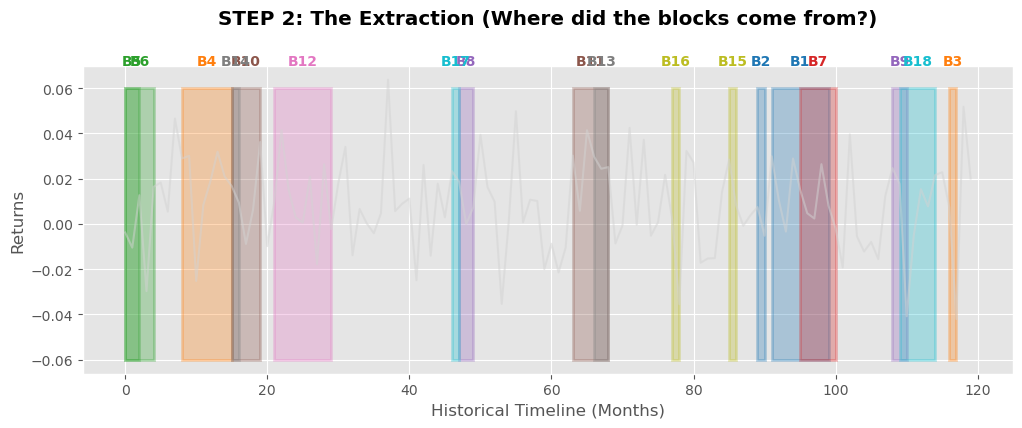

Then, we string these chunks together into a hypothetical price evolution path.



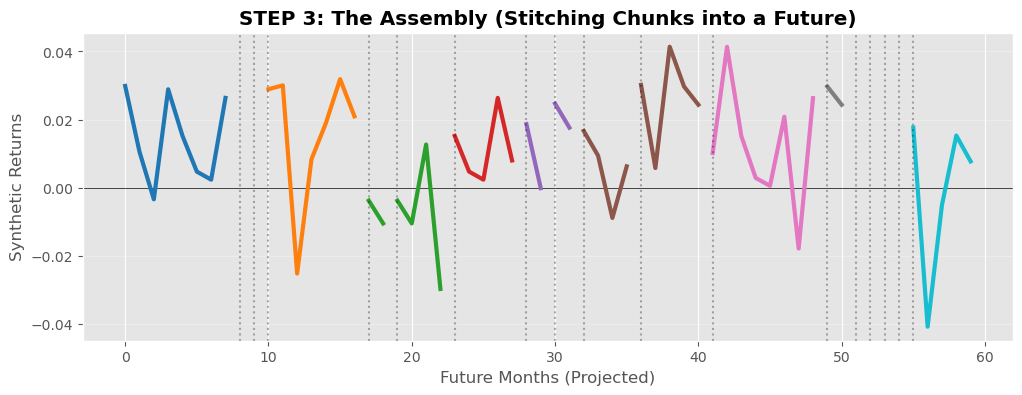

We generate several simulated histories with block-bootstrap to find the median and 5th to 95th percentile range.



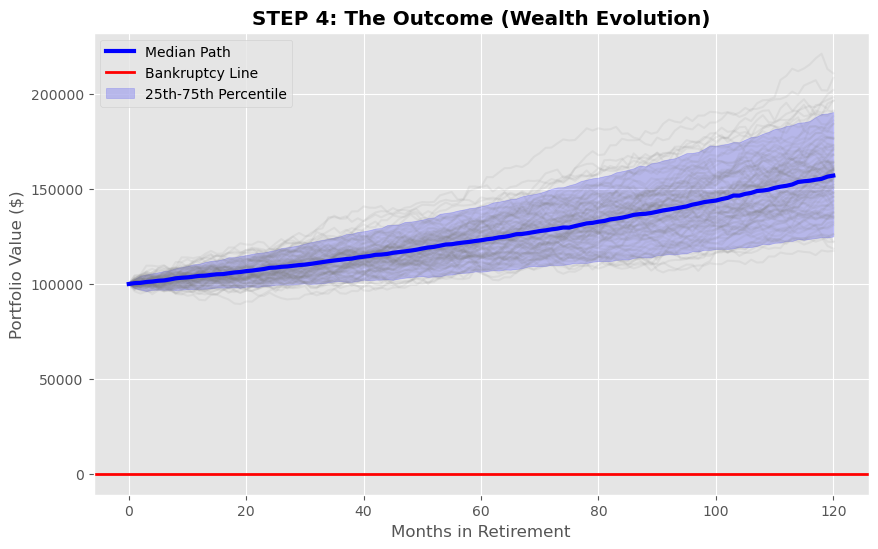

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Setup for professional visual output
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titleweight'] = 'bold'

# =================================================================
# 1. THE SOURCE: 10 Years of "Real" Market History
# =================================================================
# We create a history where assets move together (correlation)
print("First, we start with a historical returns dataset.\n")
np.random.seed(42)
history_len = 120 
mean_ret = [0.007, 0.002] # Equity vs Bonds
cov_mat = [[0.0005, 0.0001], [0.0001, 0.0001]]
history = np.random.multivariate_normal(mean_ret, cov_mat, size=history_len)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(history[:, 0], color='royalblue', lw=1, label="Historical Equity Returns")
ax.set_title("STEP 1: The 'Source Code' (Historical Data)")
ax.set_xlabel("Historical Months")
ax.legend()
plt.show()

# %% [markdown]
# ### STEP 2: The Extraction (Sampling Blocks)
# Instead of picking single dots, we pick **sequences**. 
# This preserves the "vibe" of the market (e.g., if month 5 was bad, month 6 was likely also volatile).

# %%
def pedagogical_bootstrap(data, avg_size, target_len):
    path, meta = [], []
    curr = 0
    while curr < target_len:
        start = np.random.randint(0, len(data))
        # Geometric length makes the 'rhythm' of the blocks unpredictable/natural
        length = min(np.random.geometric(1/avg_size), len(data)-start, target_len-curr)
        path.append(data[start : start + length])
        meta.append((start, length, curr))
        curr += length
    return np.vstack(path), meta

target_future = 60
synth_ret, blocks = pedagogical_bootstrap(history, 6, target_future)

# --- VISUALIZING THE EXTRACTION ---
print("Then we randomly select chunks of returns data with a chosen average block size.\n")
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(history[:, 0], color='lightgrey', alpha=0.5)
colors = plt.cm.tab10(np.linspace(0, 1, len(blocks)))

for i, (start, length, _) in enumerate(blocks):
    # Draw a box over the history where the block was 'stolen' from
    rect = patches.Rectangle((start, -0.06), length, 0.12, linewidth=2, 
                             edgecolor=colors[i], facecolor=colors[i], alpha=0.3)
    ax.add_patch(rect)
    ax.text(start + length/2, 0.07, f"B{i+1}", ha='center', color=colors[i], fontweight='bold')
ax.set_title("STEP 2: The Extraction (Where did the blocks come from?)", pad=30)
ax.set_ylabel("Returns")
ax.set_xlabel("Historical Timeline (Months)")
plt.show()

# %% [markdown]
# ### STEP 3: The Assembly (The 'Frankenstein' Path)
# We take those highlighted chunks from above and string them together chronologically 
# to build one possible "Synthetic Future."
print("Then, we string these chunks together into a hypothetical price evolution path.\n")
fig, ax = plt.subplots(figsize=(12, 4))
ax.axhline(0, color='black', lw=0.5)

for i, (start, length, path_pos) in enumerate(blocks):
    chunk = synth_ret[path_pos : path_pos + length, 0]
    ax.plot(range(path_pos, path_pos + length), chunk, color=colors[i], lw=3)
    # Visual connector (the stitch)
    if i > 0:
        ax.axvline(path_pos, color='black', linestyle=':', alpha=0.3)

ax.set_title("STEP 3: The Assembly (Stitching Chunks into a Future)")
ax.set_xlabel("Future Months (Projected)")
ax.set_ylabel("Synthetic Returns")
plt.grid(axis='y', alpha=0.3)
plt.show()

# %% [markdown]
# ### STEP 4: The Outcome (Compounding Wealth)
# Finally, we run this 1,000 times. We apply a **4% withdrawal rule**. 
# Notice how the "Sequence of Returns" (which blocks happen first) determines survival.

print("We generate several simulated histories with block-bootstrap to find the median and 5th to 95th percentile range.\n")
n_sims = 1000
future_months = 120
init_cash = 100_000
withdraw_rate = 0.04 / 12 # Monthly 4% rule
wealth_matrix = np.zeros((n_sims, future_months + 1))
wealth_matrix[:, 0] = init_cash

for s in range(n_sims):
    sim_r, _ = pedagogical_bootstrap(history, 6, future_months)
    w = init_cash
    for t in range(future_months):
        # 60/40 Portfolio return
        ret = (sim_r[t, 0] * 0.6) + (sim_r[t, 1] * 0.4)
        w = (w * (1 + ret)) - (init_cash * withdraw_rate)
        wealth_matrix[s, t+1] = max(w, 0)

# --- FINAL PLOT ---
plt.figure(figsize=(10, 6))
median_path = np.median(wealth_matrix, axis=0)
plt.plot(wealth_matrix[:100].T, color='grey', alpha=0.1) # Plot first 100 for clarity
plt.plot(median_path, color='blue', lw=3, label="Median Path")
plt.axhline(0, color='red', lw=2, label="Bankruptcy Line")
plt.fill_between(range(future_months+1), 
                 np.percentile(wealth_matrix, 5, axis=0), 
                 np.percentile(wealth_matrix, 95, axis=0), 
                 color='blue', alpha=0.2, label="25th-75th Percentile")

plt.title("STEP 4: The Outcome (Wealth Evolution)")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Months in Retirement")
plt.legend()
plt.show()